<a href="https://colab.research.google.com/github/Go-Maeda-git/pytorch_instraction/blob/main/neural_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 54.515987 Content Loss: 11.076594

run [100]:
Style Loss : 25.901850 Content Loss: 10.308249

run [150]:
Style Loss : 14.668185 Content Loss: 9.282930

run [200]:
Style Loss : 8.487418 Content Loss: 8.254369

run [250]:
Style Loss : 4.896436 Content Loss: 7.380333

run [300]:
Style Loss : 2.875021 Content Loss: 6.644429



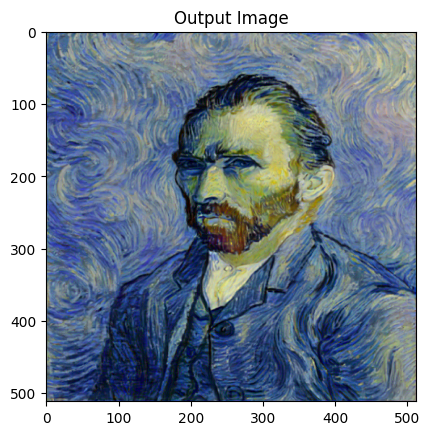

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy # モデルのコピー用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128  # GPUがない場合は小さいサイズで

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)), # 画像サイズを統一
    transforms.ToTensor()])  # テンソルに変換

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB') # <--- ここに .convert('RGB') を追加
    # loaderを通してテンソルにし、バッチ次元を追加
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# 画像をPyTorchテンソルからPIL Imageに戻す関数 (表示用)
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # GPU上にある場合はCPUにコピー
    image = image.squeeze(0)      # バッチ次元を削除
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # ターゲットとなる特徴量を detach して計算グラフから切り離す(勾配計算の対象外になる)
        self.target = target.detach()
        self.loss = nn.MSELoss() # 平均二乗誤差(スタイルがどれぐらい離れてるかの指標)

    def forward(self, input):
        self.loss_val = self.loss(input, self.target)
        return input # 次の層にそのまま渡す（損失計算自体は内部で行う）

def gram_matrix(input):
    a, b, c, d = input.size()  # a=バッチサイズ(=1)
                               # b=特徴マップの数 (チャネル数)
                               # (c,d)=特徴マップの次元 (高さ, 幅)
    features = input.view(a * b, c * d)  # 特徴マップを (チャネル数, 高さ*幅) に変形
    G = torch.mm(features, features.t())  # グラム行列を計算 (features と featuresの転置行列の内積)
    # グラム行列の値を特徴マップの要素数で正規化
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = nn.MSELoss()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss_val = self.loss(G, self.target)
        return input
cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

# VGGネットワークは0-1に正規化された画像を入力とするため、
# 画像を正規化するための平均と標準偏差 (ImageNetのデータセットのもの)
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# 正規化を行うためのカスタム nn.Module
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view(-1, 1, 1) は mean と std を [C x 1 x 1] の形に変形し、
        # 画像テンソル [B x C x H x W] に対してブロードキャストできるようにする
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        # img は [B x C x H x W]
        return (img - self.mean) / self.std

# コンテンツ損失とスタイル損失を抽出する層の名前
content_layers_default = ['conv_4'] # 一般的に中間層の深い部分
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'] # 浅い層から深い層まで

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn) # 元のCNNモデルを汚さないようにコピー

    # 正規化レイヤー
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization) # 新しいSequentialモデルの最初に正規化層を追加

    i = 0  # conv層をカウントするためのインクリメンタルなカウンタ
    for layer in cnn.children(): # VGGの各層をイテレート
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # inplace=False 版のReLUに置き換える (inplace=TrueだとContentLoss/StyleLossで問題が起きる場合がある)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d): # VGG19にはBatchNormはないが念のため
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer) # 現在の層をモデルに追加

        if name in content_layers:
            # コンテンツ損失層を追加
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # スタイル損失層を追加
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # リストの最後にある不要になったVGGの層を削除
    # (最後のcontent_lossまたはstyle_lossより後の層は不要)
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses
    # 画像をロード (ファイルパスは適宜変更してください)
style_img = image_loader("/content/スクリーンショット 2025-05-19 170653.png") # スタイル画像のパス
content_img = image_loader("/content/スクリーンショット 2025-05-19 170850.png") # コンテンツ画像のパス

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

# 最適化対象の画像を初期化 (コンテンツ画像をコピーするか、ランダムノイズで始める)
input_img = content_img.clone()
# またはランダムノイズから始める場合:
# input_img = torch.randn(content_img.data.size(), device=device)

# LBFGSオプティマイザ (論文で推奨されている)
# input_img のピクセル自体を更新するため、input_img を requires_grad_() で勾配計算対象にする
input_img.requires_grad_(True) # これを忘れないこと
optimizer = optim.LBFGS([input_img])
# またはAdamなど他のオプティマイザも使用可能
# optimizer = optim.Adam([input_img], lr=0.01)
# 学習ステップ数
num_steps = 300
# スタイル損失とコンテンツ損失の重み
style_weight = 1000000
content_weight = 1

print('Building the style transfer model..')
model, style_losses, content_losses = get_style_model_and_losses(cnn,
    cnn_normalization_mean, cnn_normalization_std, style_img, content_img)

print('Optimizing..')
run = [0]
while run[0] <= num_steps:

    def closure():
        # 入力画像のピクセル値が0-1の範囲に収まるように補正
        with torch.no_grad():
            input_img.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img) # モデルに現在の入力画像を通して、各損失レイヤーで損失を計算させる

        s_loss = 0
        c_loss = 0

        for sl in style_losses:
            s_loss += sl.loss_val
        for cl in content_losses:
            c_loss += cl.loss_val

        s_loss *= style_weight
        c_loss *= content_weight

        loss = s_loss + c_loss
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print("run {}:".format(run))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                s_loss.item(), c_loss.item()))
            print()

        return loss

    optimizer.step(closure) # LBFGSオプティマイザのステップ実行

# 最後の補正
with torch.no_grad():
    input_img.clamp_(0, 1)
plt.figure()
imshow(input_img, title='Output Image')
plt.ioff()
plt.show()

# 画像をファイルに保存する場合
output_image_pil = unloader(input_img.cpu().squeeze(0))
output_image_pil.save('output.png')